## Recurrent Neural Network

### Name: Shane Bowen

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot

## Series to Supervised Function

In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Load Dataset

In [3]:
# load dataset
df = pd.read_csv('../reports/company_report_sorted.csv', header=0)

In [4]:
df.describe()

,company_id,date,month,year,is_weekend,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
count,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,81177.000000,38582.00000,81177.000000,81177.000000,81177.000000
mean,116.341131,15.702650,5.961787,2019.019919,0.285068,1.551814,1.015817,12.236914,1.194649,634.982495,0.824926,61.958264,2.679441,17153.04712,0.474543,683.374195,0.592643
std,80.259575,8.747959,3.394279,0.754269,0.451450,1.884625,9.077087,67.588568,17.377169,1906.505863,1.035857,307.768620,26.526979,61715.58144,0.499355,4151.475787,0.491345
min,1.000000,1.000000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,53.000000,8.000000,3.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,583.00000,0.000000,0.000000,0.000000
50%,104.000000,16.000000,5.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,2000.00000,0.000000,12.000000,1.000000
75%,173.000000,23.000000,9.000000,2020.000000,1.000000,3.789976,0.000000,2.000000,0.000000,216.000000,1.000000,26.000000,0.000000,7200.00000,1.000000,156.000000,1.000000
max,372.000000,31.000000,12.000000,2020.000000,1.000000,4.500000,627.000000,4492.000000,1258.000000,13277.440000,6.000000,4267.000000,2337.000000,400000.00000,1.000000,57105.000000,1.000000


## Data Cleaning

In [5]:
# Find the number of missing data in the dataset
df.apply(lambda x: sum(x.isnull()), axis=0)

company_name                   0
company_id                     0
company_type                   0
time                           0
date                           0
month                          0
year                           0
day                            0
is_weekend                     0
season                         0
avg_pesq_score                 0
quality_too_poor               0
number_busy                    0
temporarily_unable_test        0
outage_hrs                     0
number_test_types              0
numbers_tested                 0
followup_tests                 0
min_commit                 42595
has_min_commit                 0
volume_tests                   0
is_testing                     0
dtype: int64

In [6]:
df[df['min_commit'].isnull() ]

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
4,Marchex,10,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0.0,1,13,0,NaN,0,672,1
6,Airbnb,17,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0.0,1,37,0,NaN,0,1792,1
12,Mastercard,49,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,24.0,1,10,0,NaN,0,82,1
18,Tata Communications,75,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,0,0,0.0,0,0,0,NaN,0,15,1
21,Amazon Chime,100,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,5,0,24.0,1,68,0,NaN,0,340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81172,BlackBerry,361,Enterprise,2020-06-24,24,6,2020,Wed,0,Summer,...,0,0,0.0,0,0,0,NaN,0,0,0
81173,Hoist Group,362,Enterprise,2020-06-24,24,6,2020,Wed,0,Summer,...,0,0,0.0,0,0,0,NaN,0,0,0
81174,IBM,363,Enterprise,2020-06-24,24,6,2020,Wed,0,Summer,...,0,0,0.0,0,0,0,NaN,0,0,0
81175,Siemens,364,Enterprise,2020-06-24,24,6,2020,Wed,0,Summer,...,0,0,0.0,0,0,0,NaN,0,0,0


In [7]:
# fill nan with 0
df['min_commit'] = df['min_commit'].fillna(0)
df['min_commit'].count()

81177

## Distribution Analysis

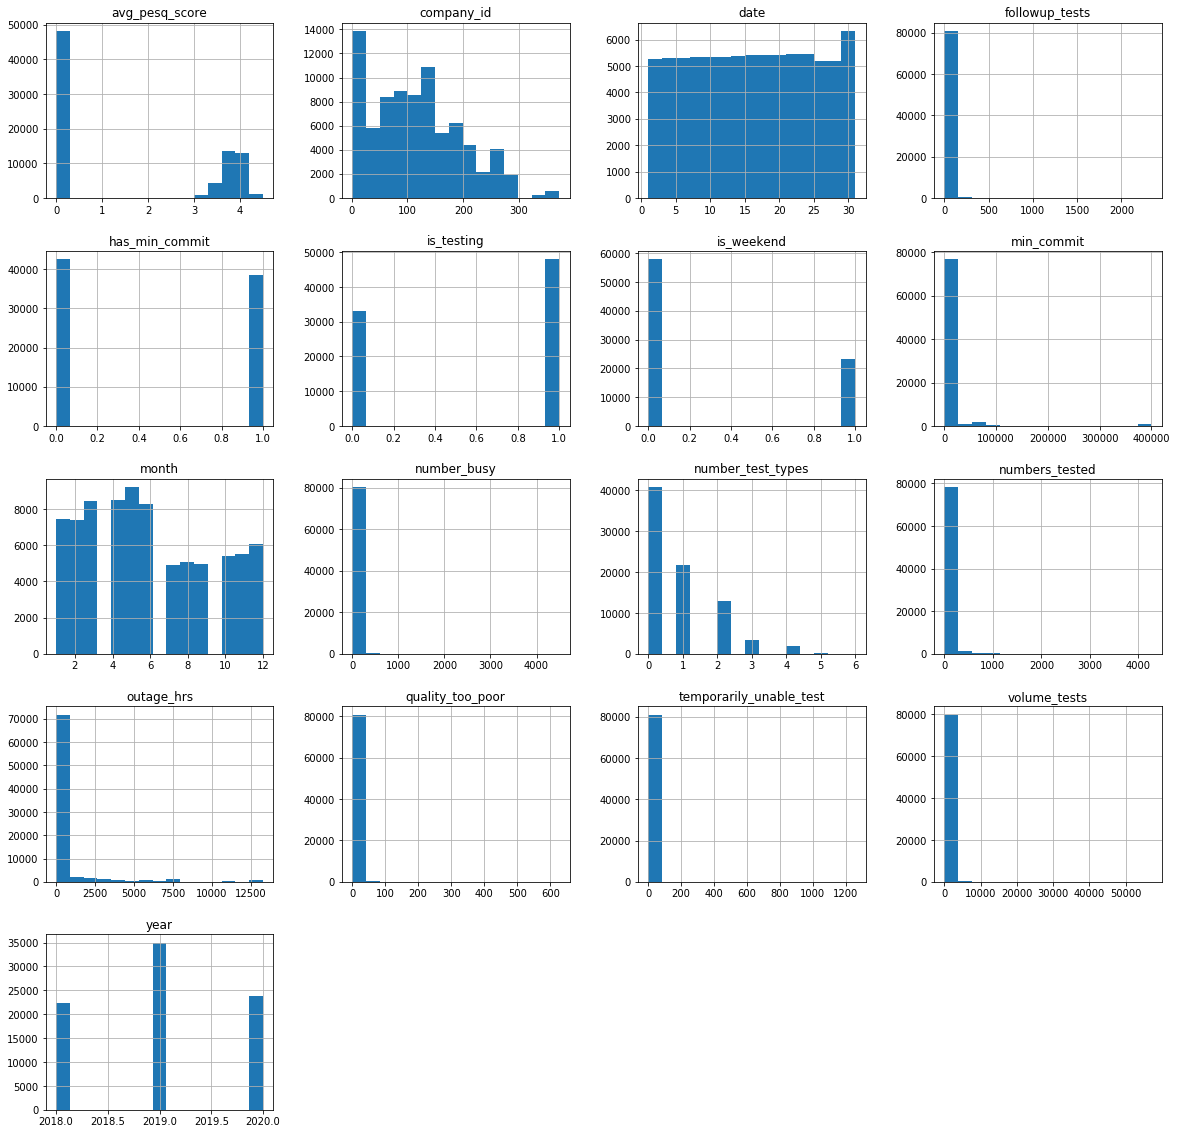

In [8]:
df.hist(bins=15, figsize=(20, 20));

## Handling Outliers

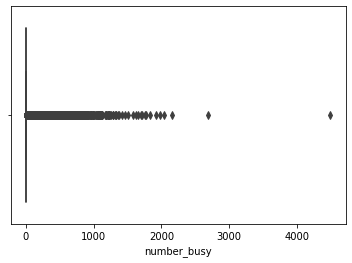

In [9]:
# plot number_busy outliers
sns.boxplot(x=df["number_busy"])

In [10]:
# count number of outliers
print((df[['number_busy']] > 2600).sum())
df[df['number_busy'] > 2600]

number_busy    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
27749,Google,2,Enterprise,2019-03-08,8,3,2019,Fri,0,Spring,...,4492,0,6478.70,3,3003,2337,400000.0,1,42615,1
48926,Tata Communications,75,Enterprise,2019-10-19,19,10,2019,Sat,1,Autumn,...,2680,0,2159.97,2,110,0,27272.0,1,5164,1


In [11]:
# remove outliers for number_busy
df = df[df['number_busy'] < 2600]

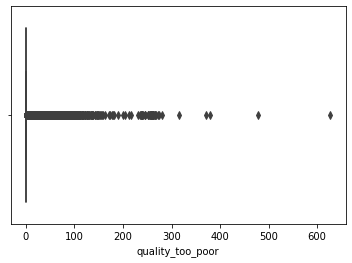

In [12]:
# plot quality_too_poor outliers
sns.boxplot(x=df["quality_too_poor"])

In [13]:
# count number of outliers
print((df[['quality_too_poor']] > 450).sum())
df[df['quality_too_poor'] > 450]

quality_too_poor    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
9282,Google,2,Enterprise,2018-06-27,27,6,2018,Wed,0,Summer,...,469,68,4353.67,3,2718,130,400000.0,1,40609,1
48585,Intrado,9,Conference,2019-10-16,16,10,2019,Wed,0,Autumn,...,33,11,2232.03,3,133,24,0.0,0,7907,1


In [14]:
# remove outliers for quality_too_poor
df = df[df['quality_too_poor'] < 450]

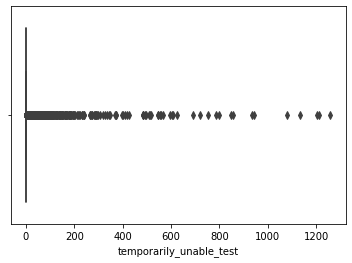

In [15]:
# plot outliers temporarily_unable_test
sns.boxplot(x=df["temporarily_unable_test"])

In [16]:
# count number of outliers
print((df[['temporarily_unable_test']] > 1000).sum())
df[df['temporarily_unable_test'] > 1000]

temporarily_unable_test    5
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
6430,Google,2,Enterprise,2018-05-11,11,5,2018,Fri,0,Summer,...,288,1079,3767.03,3,2457,90,400000.0,1,40026,1
7138,Google,2,Enterprise,2018-05-23,23,5,2018,Wed,0,Summer,...,216,1132,3717.83,3,2541,90,400000.0,1,40182,1
7870,Google,2,Enterprise,2018-06-04,4,6,2018,Mon,0,Summer,...,623,1202,4032.27,3,2500,280,400000.0,1,40047,1
15839,Google,2,Enterprise,2018-10-05,5,10,2018,Fri,0,Autumn,...,519,1258,5141.55,3,2669,350,400000.0,1,44042,1
25858,Google,2,Enterprise,2019-02-14,14,2,2019,Thurs,0,Spring,...,414,1213,5927.93,3,3038,153,400000.0,1,46280,1


In [17]:
# remove outliers for temporarily_unable_test
df = df[df['temporarily_unable_test'] < 1000]

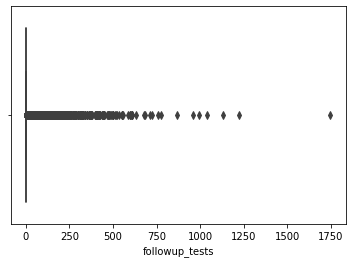

In [18]:
# plot outliers for followup_tests
sns.boxplot(x=df["followup_tests"])

In [19]:
# count number of outliers
print((df[['followup_tests']] > 1200).sum())
df[df['followup_tests'] > 1200]

followup_tests    2
dtype: int64


,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
16529,Google,2,Enterprise,2018-10-15,15,10,2018,Mon,0,Autumn,...,2155,28,5581.40,3,2862,1747,400000.0,1,45696,1
23910,Google,2,Enterprise,2019-01-21,21,1,2019,Mon,0,Winter,...,1621,0,6110.11,3,3016,1224,400000.0,1,47779,1


In [20]:
# remove outliers for followup_tests
df = df[df['followup_tests'] < 1200]

## Feature Selection

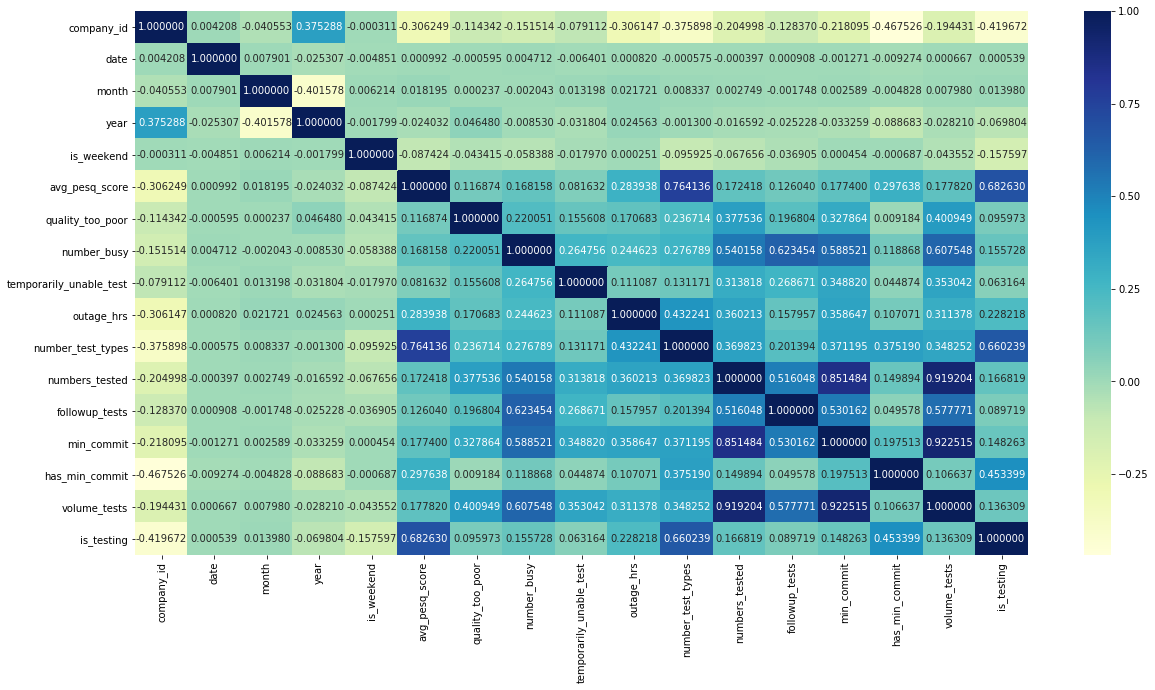

In [21]:
plt.figure(figsize=(20,10))
df_corr= df.corr()
sns.heatmap(df_corr, annot=True, fmt="f", cmap="YlGnBu")

In [22]:
# limit data to first 20 companies (reduce training time)
df_subset = df[df['company_id'] == 2]
df_subset

,company_name,company_id,company_type,time,date,month,year,day,is_weekend,season,...,number_busy,temporarily_unable_test,outage_hrs,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
1,Google,2,Enterprise,2018-01-01,1,1,2018,Mon,0,Winter,...,246,0,2208.22,2,2410,100,400000.0,1,35405,1
27,Google,2,Enterprise,2018-01-02,2,1,2018,Tues,0,Winter,...,952,0,2225.04,2,2444,434,400000.0,1,36978,1
59,Google,2,Enterprise,2018-01-03,3,1,2018,Wed,0,Winter,...,791,0,2230.62,2,2433,370,400000.0,1,36978,1
91,Google,2,Enterprise,2018-01-04,4,1,2018,Thurs,0,Winter,...,824,0,2209.19,2,2441,420,400000.0,1,35899,1
124,Google,2,Enterprise,2018-01-05,5,1,2018,Fri,0,Winter,...,637,0,2232.59,2,2336,420,400000.0,1,34504,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80427,Google,2,Enterprise,2020-06-20,20,6,2020,Sat,1,Summer,...,70,0,7343.91,6,513,9,400000.0,1,22449,1
80577,Google,2,Enterprise,2020-06-21,21,6,2020,Sun,1,Summer,...,121,9,7343.91,5,1343,42,400000.0,1,23397,1
80727,Google,2,Enterprise,2020-06-22,22,6,2020,Mon,0,Summer,...,85,45,7358.90,6,4154,50,400000.0,1,39874,1
80877,Google,2,Enterprise,2020-06-23,23,6,2020,Tues,0,Summer,...,121,0,7393.24,6,4178,55,400000.0,1,40922,1


In [23]:
# select features columns
#df_subset = df_subset[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df_subset = df_subset[['volume_tests', 'date', 'month', 'year', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit', 'has_min_commit', 'is_testing']]

In [24]:
# get datframe values
values = df_subset.values

In [25]:
# specify the number of days and features 
n_input = 7
n_features = df_subset.shape[1]
n_predict = 7

In [26]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [27]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)

In [28]:
values = reframed.values
values.shape

(884, 196)

In [29]:
# # split into train and test sets
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[:train_size], values[-test_size:]
print(train.shape, test.shape)

(707, 196) (177, 196)


In [30]:
# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features

X, y = values[:, :n_obs], values[:, -n_predict_obs::n_features]
X = X.reshape((X.shape[0], n_input, n_features))
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(X.shape, y.shape, test_X.shape, test_y.shape)

(884, 7, 14) (884, 7) (177, 98) (177, 7)


## Build Model

Train on 795 samples, validate on 89 samples
Epoch 1/100
795/795 - 3s - loss: 0.2175 - accuracy: 0.1547 - val_loss: 0.1001 - val_accuracy: 0.1573
Epoch 2/100
795/795 - 0s - loss: 0.0928 - accuracy: 0.1447 - val_loss: 0.0501 - val_accuracy: 0.2022
Epoch 3/100
795/795 - 0s - loss: 0.0671 - accuracy: 0.1547 - val_loss: 0.0476 - val_accuracy: 0.1461
Epoch 4/100
795/795 - 0s - loss: 0.0599 - accuracy: 0.1560 - val_loss: 0.0448 - val_accuracy: 0.2022
Epoch 5/100
795/795 - 0s - loss: 0.0596 - accuracy: 0.1660 - val_loss: 0.0421 - val_accuracy: 0.2697
Epoch 6/100
795/795 - 0s - loss: 0.0535 - accuracy: 0.2050 - val_loss: 0.0399 - val_accuracy: 0.2697
Epoch 7/100
795/795 - 0s - loss: 0.0499 - accuracy: 0.2050 - val_loss: 0.0380 - val_accuracy: 0.3146
Epoch 8/100
795/795 - 0s - loss: 0.0479 - accuracy: 0.2289 - val_loss: 0.0358 - val_accuracy: 0.3146
Epoch 9/100
795/795 - 0s - loss: 0.0439 - accuracy: 0.2151 - val_loss: 0.0335 - val_accuracy: 0.3034
Epoch 10/100
795/795 - 0s - loss: 0.0417 - acc

Epoch 81/100
795/795 - 0s - loss: 0.0129 - accuracy: 0.3384 - val_loss: 0.0141 - val_accuracy: 0.2472
Epoch 82/100
795/795 - 0s - loss: 0.0130 - accuracy: 0.2981 - val_loss: 0.0157 - val_accuracy: 0.2584
Epoch 83/100
795/795 - 0s - loss: 0.0139 - accuracy: 0.3296 - val_loss: 0.0134 - val_accuracy: 0.2809
Epoch 84/100
795/795 - 0s - loss: 0.0133 - accuracy: 0.3321 - val_loss: 0.0107 - val_accuracy: 0.2697
Epoch 85/100
795/795 - 0s - loss: 0.0115 - accuracy: 0.3308 - val_loss: 0.0102 - val_accuracy: 0.2921
Epoch 86/100
795/795 - 0s - loss: 0.0115 - accuracy: 0.3094 - val_loss: 0.0122 - val_accuracy: 0.2921
Epoch 87/100
795/795 - 0s - loss: 0.0111 - accuracy: 0.3270 - val_loss: 0.0135 - val_accuracy: 0.2921
Epoch 88/100
795/795 - 0s - loss: 0.0108 - accuracy: 0.3044 - val_loss: 0.0132 - val_accuracy: 0.3258
Epoch 89/100
795/795 - 0s - loss: 0.0109 - accuracy: 0.3283 - val_loss: 0.0116 - val_accuracy: 0.3034
Epoch 90/100
795/795 - 0s - loss: 0.0106 - accuracy: 0.3220 - val_loss: 0.0098 - v

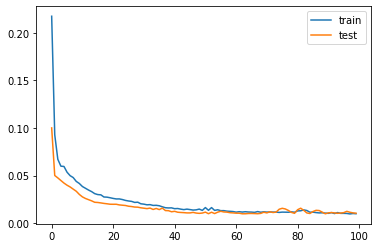

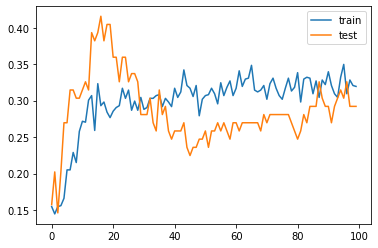

Test loss:  0.010459882322322117
Test score:  0.29213482
Train on 795 samples, validate on 89 samples
Epoch 1/100
795/795 - 0s - loss: 0.0097 - accuracy: 0.3069 - val_loss: 0.0099 - val_accuracy: 0.2921
Epoch 2/100
795/795 - 0s - loss: 0.0093 - accuracy: 0.3283 - val_loss: 0.0107 - val_accuracy: 0.2921
Epoch 3/100
795/795 - 0s - loss: 0.0095 - accuracy: 0.3283 - val_loss: 0.0106 - val_accuracy: 0.2921
Epoch 4/100
795/795 - 0s - loss: 0.0098 - accuracy: 0.3245 - val_loss: 0.0104 - val_accuracy: 0.2697
Epoch 5/100
795/795 - 0s - loss: 0.0095 - accuracy: 0.3296 - val_loss: 0.0102 - val_accuracy: 0.3146
Epoch 6/100
795/795 - 0s - loss: 0.0095 - accuracy: 0.3522 - val_loss: 0.0110 - val_accuracy: 0.3034
Epoch 7/100
795/795 - 0s - loss: 0.0094 - accuracy: 0.3195 - val_loss: 0.0109 - val_accuracy: 0.3034
Epoch 8/100
795/795 - 0s - loss: 0.0089 - accuracy: 0.3270 - val_loss: 0.0106 - val_accuracy: 0.3034
Epoch 9/100
795/795 - 0s - loss: 0.0095 - accuracy: 0.2956 - val_loss: 0.0105 - val_accura

Epoch 81/100
795/795 - 0s - loss: 0.0071 - accuracy: 0.2830 - val_loss: 0.0116 - val_accuracy: 0.3146
Epoch 82/100
795/795 - 0s - loss: 0.0069 - accuracy: 0.3019 - val_loss: 0.0125 - val_accuracy: 0.3371
Epoch 83/100
795/795 - 0s - loss: 0.0070 - accuracy: 0.2893 - val_loss: 0.0128 - val_accuracy: 0.3146
Epoch 84/100
795/795 - 0s - loss: 0.0073 - accuracy: 0.3044 - val_loss: 0.0118 - val_accuracy: 0.2697
Epoch 85/100
795/795 - 0s - loss: 0.0072 - accuracy: 0.2981 - val_loss: 0.0120 - val_accuracy: 0.3258
Epoch 86/100
795/795 - 0s - loss: 0.0069 - accuracy: 0.3270 - val_loss: 0.0126 - val_accuracy: 0.2921
Epoch 87/100
795/795 - 0s - loss: 0.0067 - accuracy: 0.2969 - val_loss: 0.0119 - val_accuracy: 0.3483
Epoch 88/100
795/795 - 0s - loss: 0.0065 - accuracy: 0.3031 - val_loss: 0.0115 - val_accuracy: 0.3258
Epoch 89/100
795/795 - 0s - loss: 0.0066 - accuracy: 0.2906 - val_loss: 0.0120 - val_accuracy: 0.2921
Epoch 90/100
795/795 - 0s - loss: 0.0069 - accuracy: 0.2478 - val_loss: 0.0120 - v

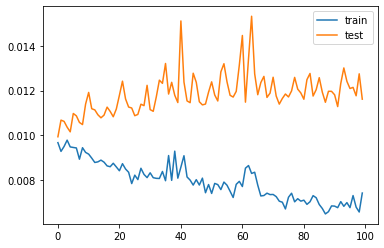

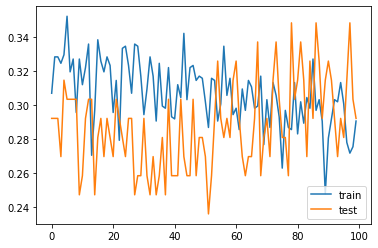

Test loss:  0.011616617441177368
Test score:  0.29213482
Train on 795 samples, validate on 89 samples
Epoch 1/100
795/795 - 0s - loss: 0.0082 - accuracy: 0.3019 - val_loss: 0.0045 - val_accuracy: 0.2921
Epoch 2/100
795/795 - 0s - loss: 0.0075 - accuracy: 0.3019 - val_loss: 0.0061 - val_accuracy: 0.3034
Epoch 3/100
795/795 - 0s - loss: 0.0079 - accuracy: 0.2994 - val_loss: 0.0044 - val_accuracy: 0.3034
Epoch 4/100
795/795 - 0s - loss: 0.0074 - accuracy: 0.3119 - val_loss: 0.0039 - val_accuracy: 0.3146
Epoch 5/100
795/795 - 0s - loss: 0.0073 - accuracy: 0.2843 - val_loss: 0.0042 - val_accuracy: 0.3708
Epoch 6/100
795/795 - 0s - loss: 0.0072 - accuracy: 0.3145 - val_loss: 0.0046 - val_accuracy: 0.3483
Epoch 7/100
795/795 - 0s - loss: 0.0076 - accuracy: 0.3069 - val_loss: 0.0041 - val_accuracy: 0.3034
Epoch 8/100
795/795 - 0s - loss: 0.0071 - accuracy: 0.2868 - val_loss: 0.0047 - val_accuracy: 0.2921
Epoch 9/100
795/795 - 0s - loss: 0.0074 - accuracy: 0.2943 - val_loss: 0.0050 - val_accura

Epoch 81/100
795/795 - 0s - loss: 0.0064 - accuracy: 0.3031 - val_loss: 0.0046 - val_accuracy: 0.3034
Epoch 82/100
795/795 - 0s - loss: 0.0062 - accuracy: 0.2792 - val_loss: 0.0045 - val_accuracy: 0.3146
Epoch 83/100
795/795 - 0s - loss: 0.0063 - accuracy: 0.2704 - val_loss: 0.0051 - val_accuracy: 0.2809
Epoch 84/100
795/795 - 0s - loss: 0.0064 - accuracy: 0.3057 - val_loss: 0.0047 - val_accuracy: 0.2472
Epoch 85/100
795/795 - 0s - loss: 0.0065 - accuracy: 0.2755 - val_loss: 0.0047 - val_accuracy: 0.3258
Epoch 86/100
795/795 - 0s - loss: 0.0064 - accuracy: 0.3006 - val_loss: 0.0055 - val_accuracy: 0.2921
Epoch 87/100
795/795 - 0s - loss: 0.0062 - accuracy: 0.2516 - val_loss: 0.0053 - val_accuracy: 0.3258
Epoch 88/100
795/795 - 0s - loss: 0.0064 - accuracy: 0.2868 - val_loss: 0.0045 - val_accuracy: 0.3371
Epoch 89/100
795/795 - 0s - loss: 0.0062 - accuracy: 0.2881 - val_loss: 0.0044 - val_accuracy: 0.3146
Epoch 90/100
795/795 - 0s - loss: 0.0063 - accuracy: 0.2893 - val_loss: 0.0057 - v

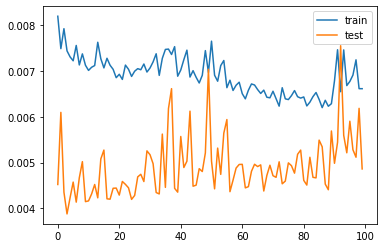

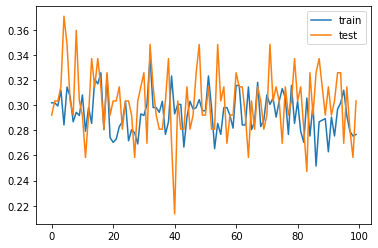

Test loss:  0.004860837232279643
Test score:  0.30337077
Train on 795 samples, validate on 89 samples
Epoch 1/100
795/795 - 0s - loss: 0.0067 - accuracy: 0.2704 - val_loss: 0.0038 - val_accuracy: 0.4270
Epoch 2/100
795/795 - 0s - loss: 0.0065 - accuracy: 0.2943 - val_loss: 0.0059 - val_accuracy: 0.3258
Epoch 3/100
795/795 - 0s - loss: 0.0073 - accuracy: 0.2893 - val_loss: 0.0029 - val_accuracy: 0.3034
Epoch 4/100
795/795 - 0s - loss: 0.0068 - accuracy: 0.2805 - val_loss: 0.0060 - val_accuracy: 0.4045
Epoch 5/100
795/795 - 0s - loss: 0.0073 - accuracy: 0.2906 - val_loss: 0.0038 - val_accuracy: 0.3596
Epoch 6/100
795/795 - 0s - loss: 0.0071 - accuracy: 0.2780 - val_loss: 0.0088 - val_accuracy: 0.3483
Epoch 7/100
795/795 - 0s - loss: 0.0083 - accuracy: 0.2906 - val_loss: 0.0038 - val_accuracy: 0.3371
Epoch 8/100
795/795 - 0s - loss: 0.0080 - accuracy: 0.2692 - val_loss: 0.0044 - val_accuracy: 0.4270
Epoch 9/100
795/795 - 0s - loss: 0.0072 - accuracy: 0.2742 - val_loss: 0.0044 - val_accura

Epoch 81/100
795/795 - 0s - loss: 0.0069 - accuracy: 0.2642 - val_loss: 0.0034 - val_accuracy: 0.2584
Epoch 82/100
795/795 - 0s - loss: 0.0063 - accuracy: 0.2943 - val_loss: 0.0037 - val_accuracy: 0.3034
Epoch 83/100
795/795 - 0s - loss: 0.0063 - accuracy: 0.2755 - val_loss: 0.0036 - val_accuracy: 0.4045
Epoch 84/100
795/795 - 0s - loss: 0.0060 - accuracy: 0.2604 - val_loss: 0.0066 - val_accuracy: 0.3258
Epoch 85/100
795/795 - 0s - loss: 0.0070 - accuracy: 0.2692 - val_loss: 0.0034 - val_accuracy: 0.2921
Epoch 86/100
795/795 - 0s - loss: 0.0064 - accuracy: 0.2918 - val_loss: 0.0036 - val_accuracy: 0.3146
Epoch 87/100
795/795 - 0s - loss: 0.0061 - accuracy: 0.2755 - val_loss: 0.0044 - val_accuracy: 0.3146
Epoch 88/100
795/795 - 0s - loss: 0.0061 - accuracy: 0.2843 - val_loss: 0.0053 - val_accuracy: 0.3258
Epoch 89/100
795/795 - 0s - loss: 0.0065 - accuracy: 0.2918 - val_loss: 0.0033 - val_accuracy: 0.2584
Epoch 90/100
795/795 - 0s - loss: 0.0062 - accuracy: 0.2717 - val_loss: 0.0036 - v

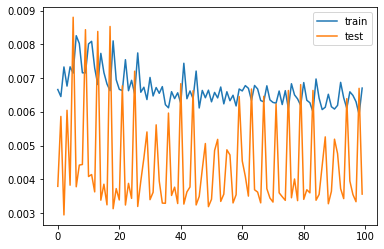

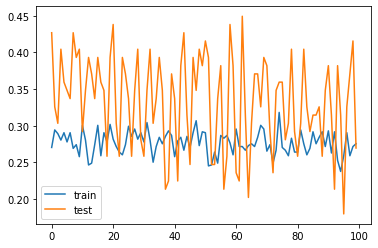

Test loss:  0.0035639818773468895
Test score:  0.26966292
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2613 - val_loss: 0.0110 - val_accuracy: 0.3977
Epoch 2/100
796/796 - 0s - loss: 0.0052 - accuracy: 0.2525 - val_loss: 0.0110 - val_accuracy: 0.4205
Epoch 3/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2764 - val_loss: 0.0120 - val_accuracy: 0.4318
Epoch 4/100
796/796 - 0s - loss: 0.0054 - accuracy: 0.2751 - val_loss: 0.0121 - val_accuracy: 0.4091
Epoch 5/100
796/796 - 0s - loss: 0.0053 - accuracy: 0.2487 - val_loss: 0.0113 - val_accuracy: 0.4091
Epoch 6/100
796/796 - 0s - loss: 0.0053 - accuracy: 0.2500 - val_loss: 0.0113 - val_accuracy: 0.3977
Epoch 7/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2626 - val_loss: 0.0119 - val_accuracy: 0.3636
Epoch 8/100
796/796 - 0s - loss: 0.0052 - accuracy: 0.2776 - val_loss: 0.0123 - val_accuracy: 0.4205
Epoch 9/100
796/796 - 0s - loss: 0.0054 - accuracy: 0.2437 - val_loss: 0.0117 - val_accur

Epoch 81/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2538 - val_loss: 0.0127 - val_accuracy: 0.3409
Epoch 82/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2726 - val_loss: 0.0131 - val_accuracy: 0.3295
Epoch 83/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2827 - val_loss: 0.0141 - val_accuracy: 0.3295
Epoch 84/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2601 - val_loss: 0.0133 - val_accuracy: 0.3523
Epoch 85/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2688 - val_loss: 0.0127 - val_accuracy: 0.3295
Epoch 86/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2751 - val_loss: 0.0144 - val_accuracy: 0.3182
Epoch 87/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2525 - val_loss: 0.0142 - val_accuracy: 0.3182
Epoch 88/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2676 - val_loss: 0.0130 - val_accuracy: 0.3523
Epoch 89/100
796/796 - 0s - loss: 0.0052 - accuracy: 0.2462 - val_loss: 0.0130 - val_accuracy: 0.3409
Epoch 90/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2864 - val_loss: 0.0145 - v

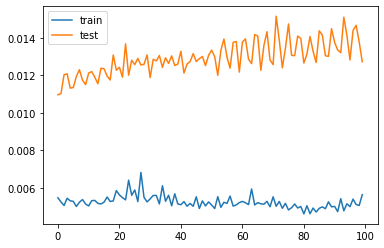

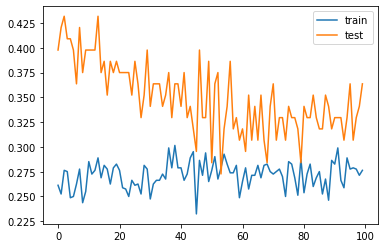

Test loss:  0.012724081699905748
Test score:  0.36363637
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0061 - accuracy: 0.2563 - val_loss: 0.0021 - val_accuracy: 0.4432
Epoch 2/100
796/796 - 0s - loss: 0.0063 - accuracy: 0.2500 - val_loss: 0.0023 - val_accuracy: 0.4773
Epoch 3/100
796/796 - 0s - loss: 0.0059 - accuracy: 0.2739 - val_loss: 0.0039 - val_accuracy: 0.4091
Epoch 4/100
796/796 - 0s - loss: 0.0069 - accuracy: 0.2563 - val_loss: 0.0023 - val_accuracy: 0.3864
Epoch 5/100
796/796 - 0s - loss: 0.0061 - accuracy: 0.2701 - val_loss: 0.0018 - val_accuracy: 0.4545
Epoch 6/100
796/796 - 0s - loss: 0.0058 - accuracy: 0.2965 - val_loss: 0.0036 - val_accuracy: 0.4091
Epoch 7/100
796/796 - 0s - loss: 0.0063 - accuracy: 0.2588 - val_loss: 0.0029 - val_accuracy: 0.3977
Epoch 8/100
796/796 - 0s - loss: 0.0061 - accuracy: 0.2538 - val_loss: 0.0028 - val_accuracy: 0.4659
Epoch 9/100
796/796 - 0s - loss: 0.0059 - accuracy: 0.2776 - val_loss: 0.0022 - val_accura

Epoch 81/100
796/796 - 0s - loss: 0.0053 - accuracy: 0.2739 - val_loss: 0.0039 - val_accuracy: 0.3977
Epoch 82/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2852 - val_loss: 0.0027 - val_accuracy: 0.3977
Epoch 83/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2638 - val_loss: 0.0047 - val_accuracy: 0.3977
Epoch 84/100
796/796 - 0s - loss: 0.0058 - accuracy: 0.2588 - val_loss: 0.0052 - val_accuracy: 0.4205
Epoch 85/100
796/796 - 0s - loss: 0.0054 - accuracy: 0.2563 - val_loss: 0.0032 - val_accuracy: 0.3409
Epoch 86/100
796/796 - 0s - loss: 0.0061 - accuracy: 0.2425 - val_loss: 0.0029 - val_accuracy: 0.3523
Epoch 87/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2513 - val_loss: 0.0047 - val_accuracy: 0.4205
Epoch 88/100
796/796 - 0s - loss: 0.0054 - accuracy: 0.2802 - val_loss: 0.0035 - val_accuracy: 0.4318
Epoch 89/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2764 - val_loss: 0.0027 - val_accuracy: 0.3409
Epoch 90/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2676 - val_loss: 0.0039 - v

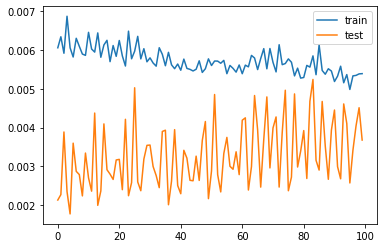

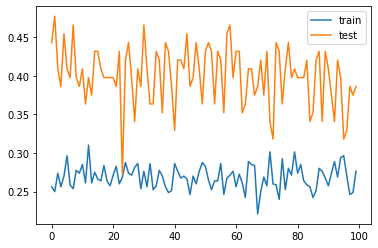

Test loss:  0.0036764199295165863
Test score:  0.38636363
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2563 - val_loss: 0.0038 - val_accuracy: 0.2500
Epoch 2/100
796/796 - 0s - loss: 0.0061 - accuracy: 0.2538 - val_loss: 0.0013 - val_accuracy: 0.3409
Epoch 3/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.3065 - val_loss: 0.0020 - val_accuracy: 0.3864
Epoch 4/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2676 - val_loss: 0.0013 - val_accuracy: 0.3523
Epoch 5/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2663 - val_loss: 0.0031 - val_accuracy: 0.2727
Epoch 6/100
796/796 - 0s - loss: 0.0059 - accuracy: 0.2739 - val_loss: 9.9738e-04 - val_accuracy: 0.3636
Epoch 7/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2374 - val_loss: 0.0017 - val_accuracy: 0.4205
Epoch 8/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2487 - val_loss: 0.0025 - val_accuracy: 0.3636
Epoch 9/100
796/796 - 0s - loss: 0.0058 - accuracy: 0.2588 - val_loss: 0.0014 - val_a

Epoch 81/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2475 - val_loss: 0.0025 - val_accuracy: 0.3523
Epoch 82/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2977 - val_loss: 0.0032 - val_accuracy: 0.3636
Epoch 83/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2500 - val_loss: 0.0023 - val_accuracy: 0.3182
Epoch 84/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2500 - val_loss: 0.0023 - val_accuracy: 0.3977
Epoch 85/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2789 - val_loss: 0.0015 - val_accuracy: 0.3636
Epoch 86/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2877 - val_loss: 0.0035 - val_accuracy: 0.3068
Epoch 87/100
796/796 - 0s - loss: 0.0058 - accuracy: 0.2638 - val_loss: 0.0018 - val_accuracy: 0.3409
Epoch 88/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2802 - val_loss: 0.0014 - val_accuracy: 0.2727
Epoch 89/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2688 - val_loss: 0.0024 - val_accuracy: 0.3523
Epoch 90/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2374 - val_loss: 0.0015 - v

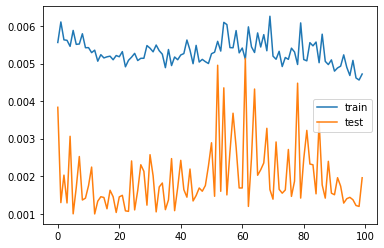

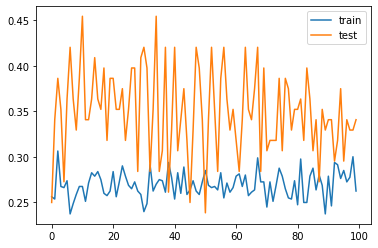

Test loss:  0.0019578203897584567
Test score:  0.3409091
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2412 - val_loss: 0.0025 - val_accuracy: 0.2727
Epoch 2/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2613 - val_loss: 0.0027 - val_accuracy: 0.3068
Epoch 3/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2764 - val_loss: 0.0023 - val_accuracy: 0.3295
Epoch 4/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2550 - val_loss: 0.0032 - val_accuracy: 0.2386
Epoch 5/100
796/796 - 0s - loss: 0.0057 - accuracy: 0.2739 - val_loss: 0.0028 - val_accuracy: 0.2955
Epoch 6/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2613 - val_loss: 0.0024 - val_accuracy: 0.2159
Epoch 7/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2701 - val_loss: 0.0030 - val_accuracy: 0.2841
Epoch 8/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2839 - val_loss: 0.0027 - val_accuracy: 0.2727
Epoch 9/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2450 - val_loss: 0.0027 - val_accura

Epoch 81/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2739 - val_loss: 0.0047 - val_accuracy: 0.3068
Epoch 82/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2613 - val_loss: 0.0032 - val_accuracy: 0.3182
Epoch 83/100
796/796 - 0s - loss: 0.0054 - accuracy: 0.2563 - val_loss: 0.0037 - val_accuracy: 0.2159
Epoch 84/100
796/796 - 0s - loss: 0.0057 - accuracy: 0.2236 - val_loss: 0.0035 - val_accuracy: 0.3182
Epoch 85/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2538 - val_loss: 0.0030 - val_accuracy: 0.2727
Epoch 86/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2726 - val_loss: 0.0039 - val_accuracy: 0.1932
Epoch 87/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2764 - val_loss: 0.0034 - val_accuracy: 0.2386
Epoch 88/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2487 - val_loss: 0.0042 - val_accuracy: 0.2841
Epoch 89/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2902 - val_loss: 0.0040 - val_accuracy: 0.2614
Epoch 90/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2487 - val_loss: 0.0036 - v

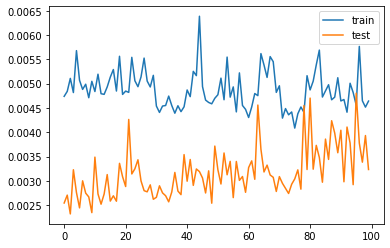

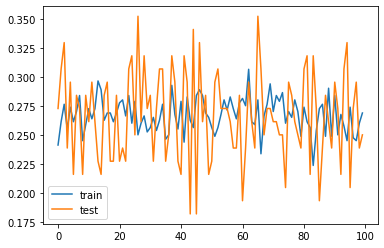

Test loss:  0.0032339161050251937
Test score:  0.25
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2852 - val_loss: 9.9825e-04 - val_accuracy: 0.3977
Epoch 2/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.3028 - val_loss: 0.0011 - val_accuracy: 0.4318
Epoch 3/100
796/796 - 0s - loss: 0.0051 - accuracy: 0.2601 - val_loss: 0.0013 - val_accuracy: 0.4432
Epoch 4/100
796/796 - 0s - loss: 0.0055 - accuracy: 0.2399 - val_loss: 0.0014 - val_accuracy: 0.4091
Epoch 5/100
796/796 - 0s - loss: 0.0049 - accuracy: 0.2550 - val_loss: 0.0011 - val_accuracy: 0.3636
Epoch 6/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2538 - val_loss: 0.0011 - val_accuracy: 0.4432
Epoch 7/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2487 - val_loss: 0.0012 - val_accuracy: 0.3977
Epoch 8/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2915 - val_loss: 0.0017 - val_accuracy: 0.4545
Epoch 9/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2827 - val_loss: 0.0010 - val_accurac

Epoch 81/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2450 - val_loss: 0.0022 - val_accuracy: 0.3864
Epoch 82/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2638 - val_loss: 0.0027 - val_accuracy: 0.4318
Epoch 83/100
796/796 - 0s - loss: 0.0044 - accuracy: 0.2889 - val_loss: 0.0014 - val_accuracy: 0.3750
Epoch 84/100
796/796 - 0s - loss: 0.0043 - accuracy: 0.2827 - val_loss: 0.0015 - val_accuracy: 0.4432
Epoch 85/100
796/796 - 0s - loss: 0.0045 - accuracy: 0.2450 - val_loss: 0.0020 - val_accuracy: 0.4318
Epoch 86/100
796/796 - 0s - loss: 0.0043 - accuracy: 0.2751 - val_loss: 0.0016 - val_accuracy: 0.3864
Epoch 87/100
796/796 - 0s - loss: 0.0043 - accuracy: 0.2387 - val_loss: 0.0016 - val_accuracy: 0.4318
Epoch 88/100
796/796 - 0s - loss: 0.0045 - accuracy: 0.2550 - val_loss: 0.0015 - val_accuracy: 0.4318
Epoch 89/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2676 - val_loss: 0.0018 - val_accuracy: 0.4318
Epoch 90/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2575 - val_loss: 0.0023 - v

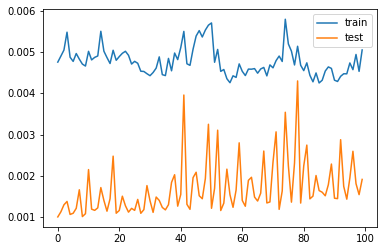

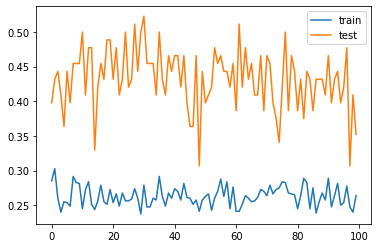

Test loss:  0.001909845910797065
Test score:  0.35227272
Train on 796 samples, validate on 88 samples
Epoch 1/100
796/796 - 0s - loss: 0.0057 - accuracy: 0.2425 - val_loss: 0.0018 - val_accuracy: 0.2614
Epoch 2/100
796/796 - 0s - loss: 0.0048 - accuracy: 0.2638 - val_loss: 0.0018 - val_accuracy: 0.2386
Epoch 3/100
796/796 - 0s - loss: 0.0046 - accuracy: 0.2638 - val_loss: 0.0017 - val_accuracy: 0.2159
Epoch 4/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2676 - val_loss: 0.0014 - val_accuracy: 0.3182
Epoch 5/100
796/796 - 0s - loss: 0.0042 - accuracy: 0.2550 - val_loss: 0.0023 - val_accuracy: 0.2614
Epoch 6/100
796/796 - 0s - loss: 0.0045 - accuracy: 0.2538 - val_loss: 0.0016 - val_accuracy: 0.2045
Epoch 7/100
796/796 - 0s - loss: 0.0044 - accuracy: 0.2500 - val_loss: 0.0019 - val_accuracy: 0.3409
Epoch 8/100
796/796 - 0s - loss: 0.0043 - accuracy: 0.2764 - val_loss: 0.0022 - val_accuracy: 0.2386
Epoch 9/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2701 - val_loss: 0.0016 - val_accura

Epoch 81/100
796/796 - 0s - loss: 0.0050 - accuracy: 0.2588 - val_loss: 0.0026 - val_accuracy: 0.2273
Epoch 82/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2462 - val_loss: 0.0025 - val_accuracy: 0.2727
Epoch 83/100
796/796 - 0s - loss: 0.0058 - accuracy: 0.2538 - val_loss: 0.0020 - val_accuracy: 0.1932
Epoch 84/100
796/796 - 0s - loss: 0.0056 - accuracy: 0.2425 - val_loss: 0.0031 - val_accuracy: 0.3295
Epoch 85/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.3266 - val_loss: 0.0024 - val_accuracy: 0.2273
Epoch 86/100
796/796 - 0s - loss: 0.0041 - accuracy: 0.2739 - val_loss: 0.0019 - val_accuracy: 0.2159
Epoch 87/100
796/796 - 0s - loss: 0.0047 - accuracy: 0.2651 - val_loss: 0.0024 - val_accuracy: 0.3068
Epoch 88/100
796/796 - 0s - loss: 0.0041 - accuracy: 0.2676 - val_loss: 0.0023 - val_accuracy: 0.2045
Epoch 89/100
796/796 - 0s - loss: 0.0040 - accuracy: 0.2513 - val_loss: 0.0022 - val_accuracy: 0.2386
Epoch 90/100
796/796 - 0s - loss: 0.0042 - accuracy: 0.2651 - val_loss: 0.0022 - v

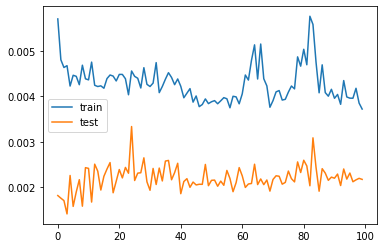

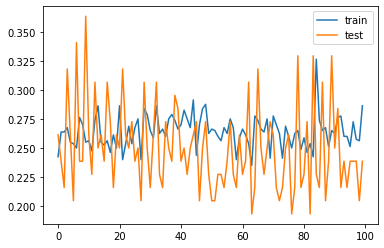

Test loss:  0.0021764355478808284
Test score:  0.23863636


In [31]:
# design LSTM Model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='relu'))
optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# store score & loss for each fold
score_arr = []
loss_arr = []

# num split for cross-validation
num_splits = 10

# k-fold cross validation
kf = KFold(n_splits=num_splits)
kf.get_n_splits(X)
KFold(n_splits=num_splits, random_state=None, shuffle=False)

# begin cross-validation procedure
for train_index, test_index in kf.split(X):
    
    # split x and y into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit Model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    # plot loss history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # plot loss history
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
        
    # Score model
    X = X.reshape((X.shape[0], n_input, n_features))
    loss, score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss: ', loss)
    print('Test score: ', score)
    
    loss_arr.append(loss)
    score_arr.append(score)

## Prepare Prediction

In [32]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

# initialize empty pred_arr and actual_arr
pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

# invert scaling for forecast
for i in range(0, yhat.shape[1]):
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = np.concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

# invert scaling for actual
for i in range(0, test_y.shape[1]):
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = np.concatenate((test_y_col, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]

(177, 7)
(177, 13)


## Evaluate Model

In [33]:
# summarize k-fold results
for i in range(len(score_arr)):
    print('K-Fold {}: Loss:{:.4f}, Score:{:.3f}'.format(i+1, loss_arr[i], score_arr[i] * 100))

K-Fold 1: Loss:0.0105, Score:29.213
K-Fold 2: Loss:0.0116, Score:29.213
K-Fold 3: Loss:0.0049, Score:30.337
K-Fold 4: Loss:0.0036, Score:26.966
K-Fold 5: Loss:0.0127, Score:36.364
K-Fold 6: Loss:0.0037, Score:38.636
K-Fold 7: Loss:0.0020, Score:34.091
K-Fold 8: Loss:0.0032, Score:25.000
K-Fold 9: Loss:0.0019, Score:35.227
K-Fold 10: Loss:0.0022, Score:23.864


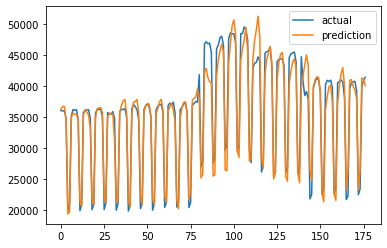

In [34]:
# plot actual vs prediction
plt.plot(list(inv_y), label='actual')
plt.plot(list(inv_yhat), label='prediction')
plt.legend()
plt.show()

In [35]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

expected_total = 0
predicted_total = 0

for i in range(len(inv_y)):
    expected_total += inv_y[i][0]
    predicted_total += inv_yhat[i][0]
print(expected_total)
print(predicted_total)

if expected_total > predicted_total:
    score = predicted_total / expected_total * 100
else:
    score = expected_total / predicted_total * 100
    
    
print("Avg. Accuracy %.2f%% " % (score))

6260558.0
6247537.304917693
Avg. Accuracy 99.79% 


In [36]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

# print predicted vs expected
accuracy_scores = []
for i in range(len(inv_y)):
    if inv_y[i] == inv_yhat[i]:
        score = 100
        accuracy_scores.append(score)
    elif inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("Avg. Accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

Day=1, Expected=36174.00, Predicted=35749.95, Accuracy=98.83%
Day=2, Expected=36055.00, Predicted=37193.40, Accuracy=96.94%
Day=3, Expected=34601.00, Predicted=35394.65, Accuracy=97.76%
Day=4, Expected=19900.00, Predicted=21365.78, Accuracy=93.14%
Day=5, Expected=20997.00, Predicted=21354.05, Accuracy=98.33%
Day=6, Expected=35692.00, Predicted=35614.23, Accuracy=99.78%
Day=7, Expected=36041.00, Predicted=35269.21, Accuracy=97.86%
Day=8, Expected=35948.00, Predicted=35201.72, Accuracy=97.92%
Day=9, Expected=36042.00, Predicted=35891.53, Accuracy=99.58%
Day=10, Expected=34633.00, Predicted=33958.26, Accuracy=98.05%
Day=11, Expected=19893.00, Predicted=20678.14, Accuracy=96.20%
Day=12, Expected=20746.00, Predicted=21085.83, Accuracy=98.39%
Day=13, Expected=35112.00, Predicted=34609.46, Accuracy=98.57%
Day=14, Expected=36206.00, Predicted=35481.42, Accuracy=98.00%
Day=15, Expected=36065.00, Predicted=35038.32, Accuracy=97.15%
Day=16, Expected=36181.00, Predicted=36685.42, Accuracy=98.63%
D

In [37]:
print("\n######  RMSE #######\n")

rmse_arr = []
# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    rmse_arr.append(rmse)
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))
print('Avg. RMSE: {:.3f}'.format(np.mean(rmse_arr)))
    
print("\n######  MAE  #######\n")
    
mae_arr = []
# calculate MAE
for i in range(0, actual_arr.shape[1]):
    mae = mean_absolute_error(actual_arr[:, i], pred_arr[:, i])
    mae_arr.append(mae)
    print('t+{} MAE: {:.3f}'.format(i+1, mae))
print('Avg. MAE: {:.3f}'.format(np.mean(mae_arr)))


######  RMSE #######

t+1 RMSE: 1470.314
t+2 RMSE: 1563.236
t+3 RMSE: 1793.321
t+4 RMSE: 2115.821
t+5 RMSE: 2205.829
t+6 RMSE: 2062.754
t+7 RMSE: 2105.941
Avg. RMSE: 1902.460

######  MAE  #######

t+1 MAE: 1143.209
t+2 MAE: 1135.589
t+3 MAE: 1247.874
t+4 MAE: 1476.983
t+5 MAE: 1513.368
t+6 MAE: 1419.089
t+7 MAE: 1505.785
Avg. MAE: 1348.842


In [38]:
model.evaluate(test_X, test_y)

177/177 [==============================] - 0s 237us/sample - loss: 0.0015 - accuracy: 0.3220


[0.0015123659609369722, 0.3220339]